In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from util import RuleClassifier
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
feature_precisions = [2, 2]

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [8]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.logodds.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.96 s, sys: 129 ms, total: 6.09 s
Wall time: 6.42 s


In [7]:
with open('shap.logodds.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = \
        pickle.load(f)

In [8]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 2), (0,), (0,))

In [9]:
xlim = explanations.data[:, 0].min() - 0.5, explanations.data[:, 0].max() + 0.5
ylim = explanations.data[:, 1].min() - 0.5, explanations.data[:, 1].max() + 0.5

# Traditional SHAP Explanations

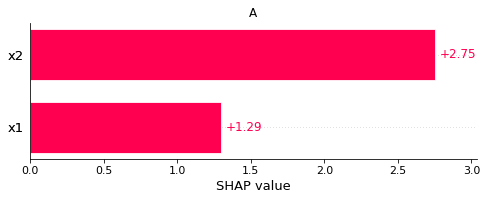

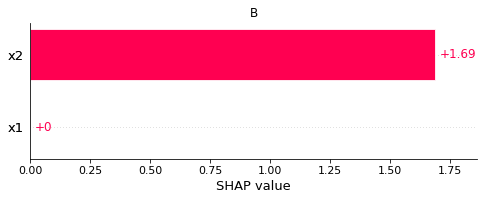

In [12]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [13]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])

In [14]:
node, Z = make_clustering(comparer, explanations.indiv.log_odds[:, :, 1])

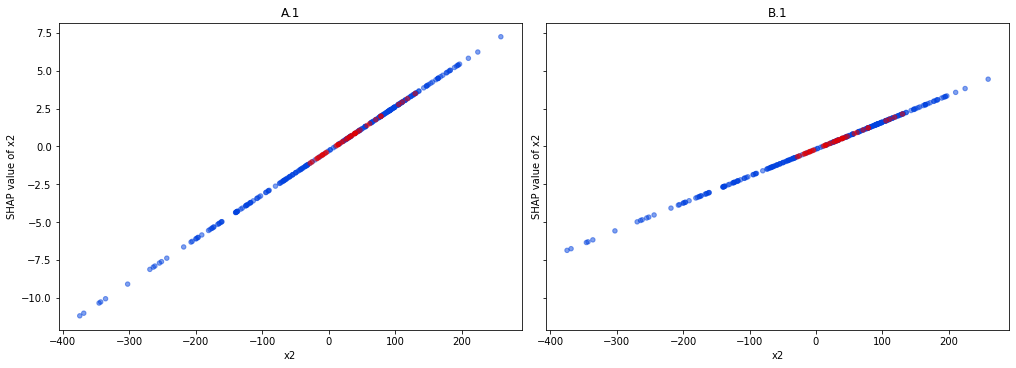

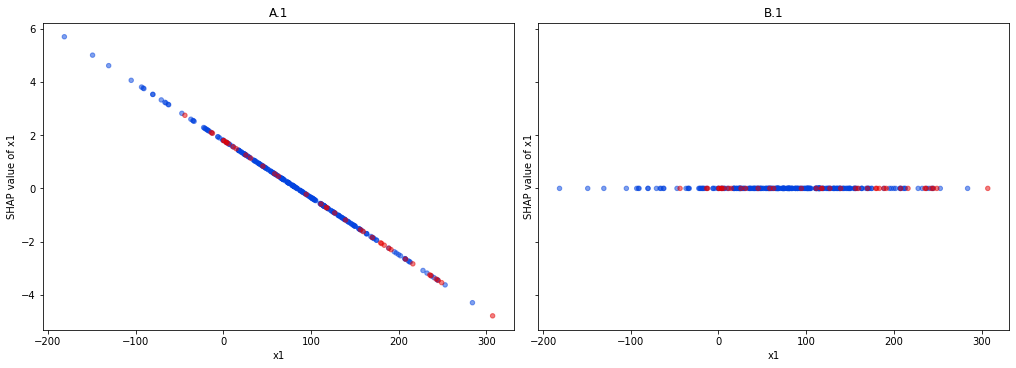

In [15]:
for feature in feature_order:
    node.plot_feature(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

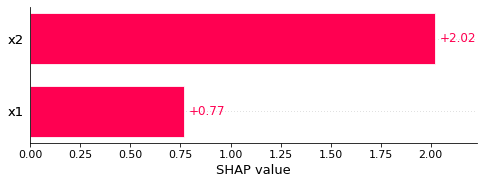

In [10]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [11]:
global_feature_order = np.arange(len(feature_order))

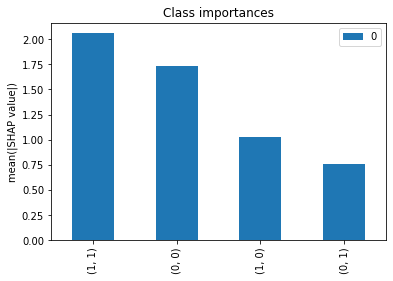

In [12]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [128]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'])

### Node R

In [129]:
node.class_counts, node.distance

((1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 882.7363012595714)

In [130]:
node = node.root.get_right()
node.class_counts, node.distance

((1, 1)    149
 (0, 0)     53
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 273.59492770205946)

In [131]:
node.get_left().class_counts

(1, 1)    40
(0, 1)     4
dtype: int64

94.55361439361346 <= x1
x1 <= 81.0 --> {'(1, 1)': 22}


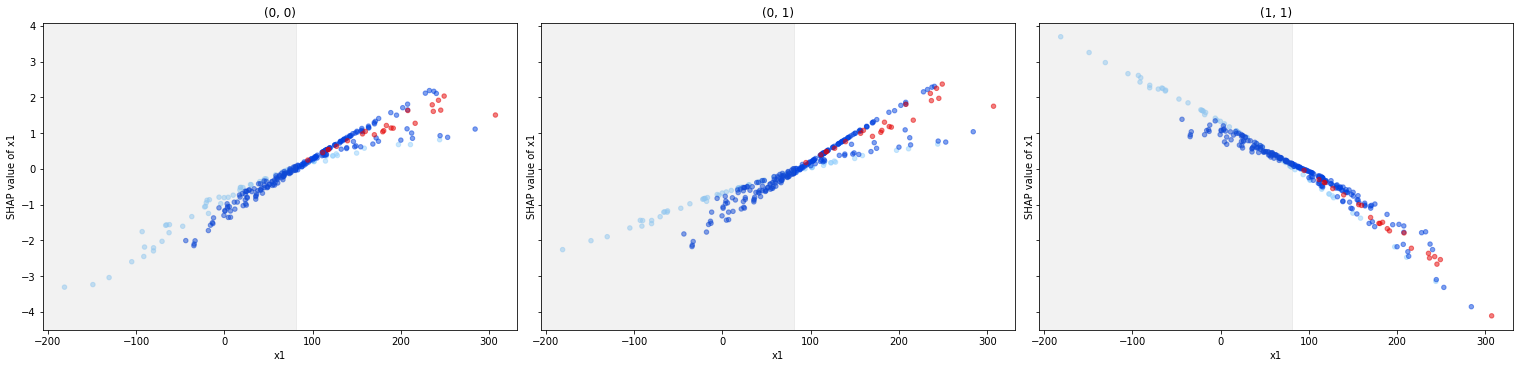

21.71322062603863 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 22}
x2 >= 189.0 --> {'(1, 1)': 22}


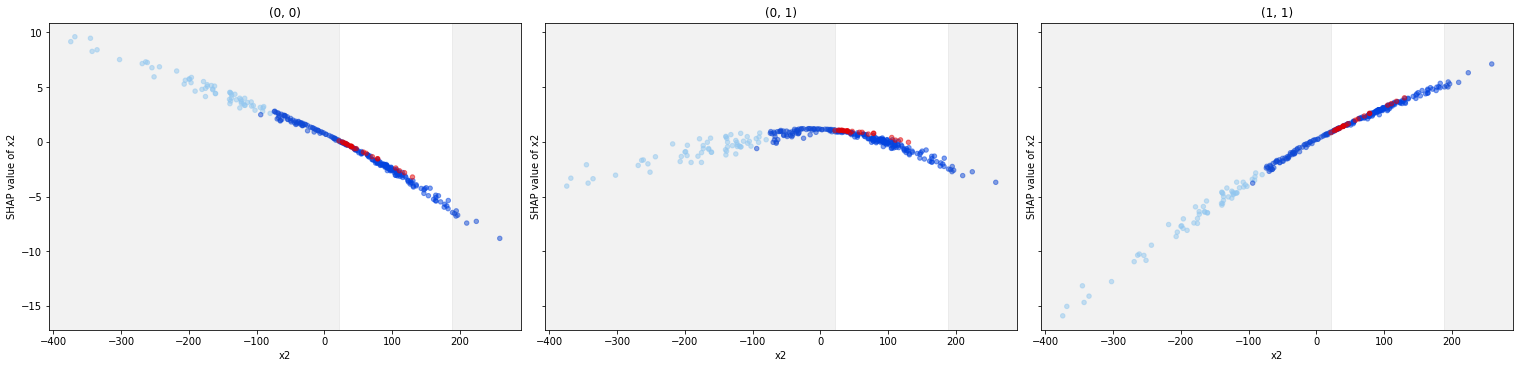

In [18]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

From a global perspective:
- x1
    - $(0,0)$: monotonically increasing
    - $(0,1)$: monotonically increasing
    - $(1,1)$: monotonically decreasing
- x2
    - $(0,0)$: monotonically decreasing
    - $(0,1)$: monotonically increasing until ~0, then monotonically decreasing
    - $(1,1)$: monotonically increasing

$(0,1)$ is most probable for high values of x1 and values around 0 of x2.

In the dependence plots, there are interaction effects present. They are stronger for x1.

The vertical spread of the SHAP values indicates feature interactions and there seems to be structure to it. By coloring the plots by the other feature respectively, I can visualize that. In this simple case, it's clear which features are interacting, because there are only two.

For high values of x2, the dependence on x1 of both $(0,0)$ and $(0,1)$ are steeper while $(1,1)$ is less steep. For low values, the opposite is the case.

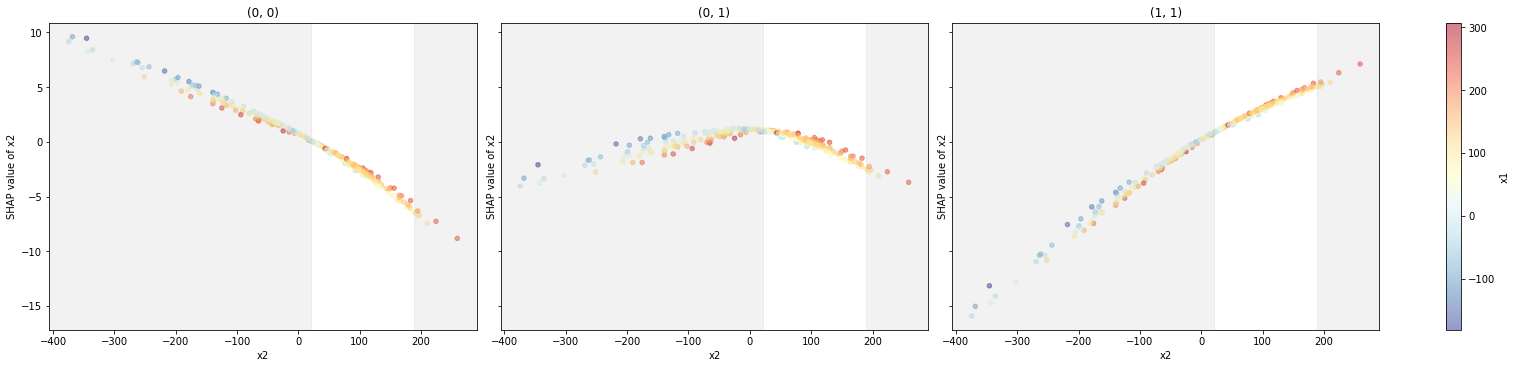

In [16]:
node.plot_feature('x2', alpha=0.5, color='x1')

For high values of x1, the dependence on x2 is steeper of $(1,1)$, less steep of $(0,0)$ and the highest point of influence on $(0,1)$ is higher, around 50.

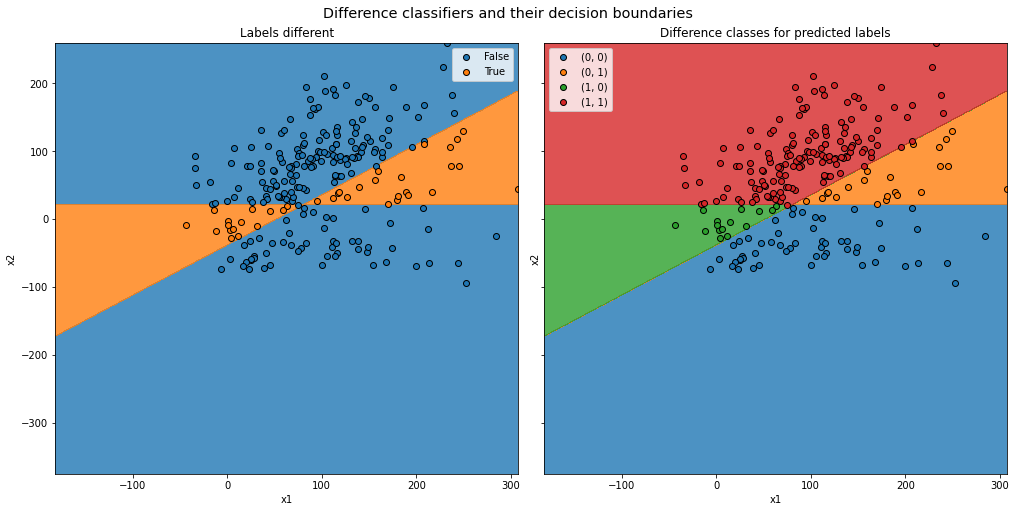

In [133]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLRL

I now descend the hierarchy until the last node, where all four instances classified $(0,1)$ are together

In [71]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    40
 (0, 1)     4
 dtype: int64,
 72.74053168607495)

In [72]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    21
 (0, 1)     4
 dtype: int64,
 18.31262902076702)

In [73]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    15
 (0, 1)     4
 dtype: int64,
 14.782257134450727)

In [74]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    4
 (1, 1)    2
 dtype: int64,
 2.752378495218214)

In [75]:
node.get_left().class_counts

(0, 1)    2
dtype: int64

207.88011354547447 <= x1 <= 249.04127642882824
x1 <= 194.0 --> {'(1, 1)': 4}


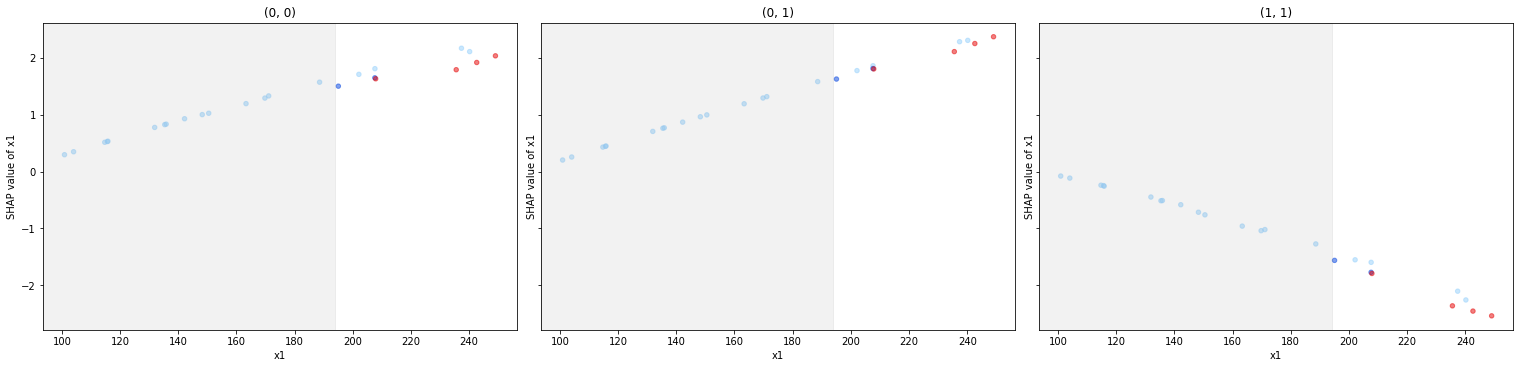

105.35039011208185 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 4}
x2 >= 146.0 --> {'(1, 1)': 4}


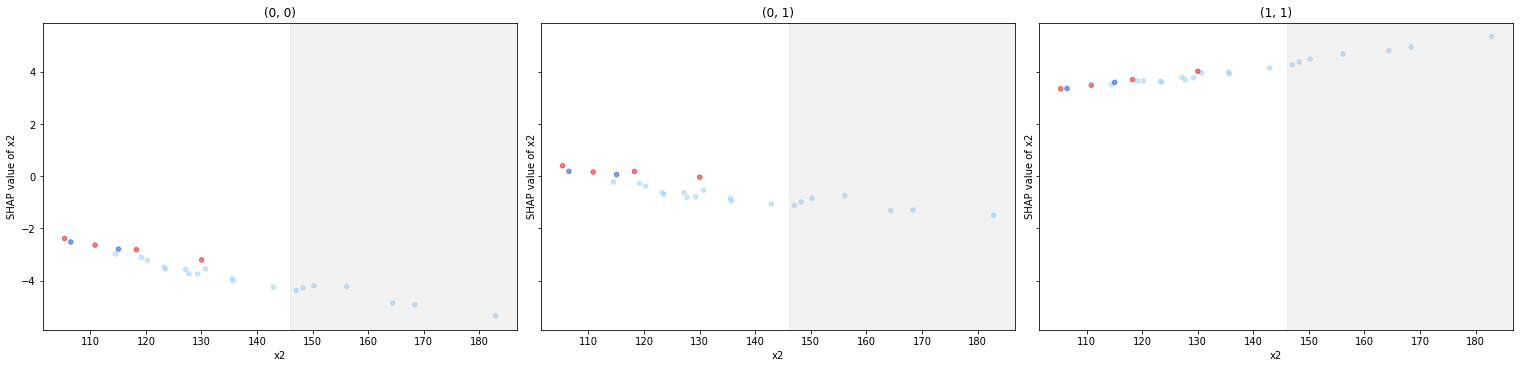

In [76]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

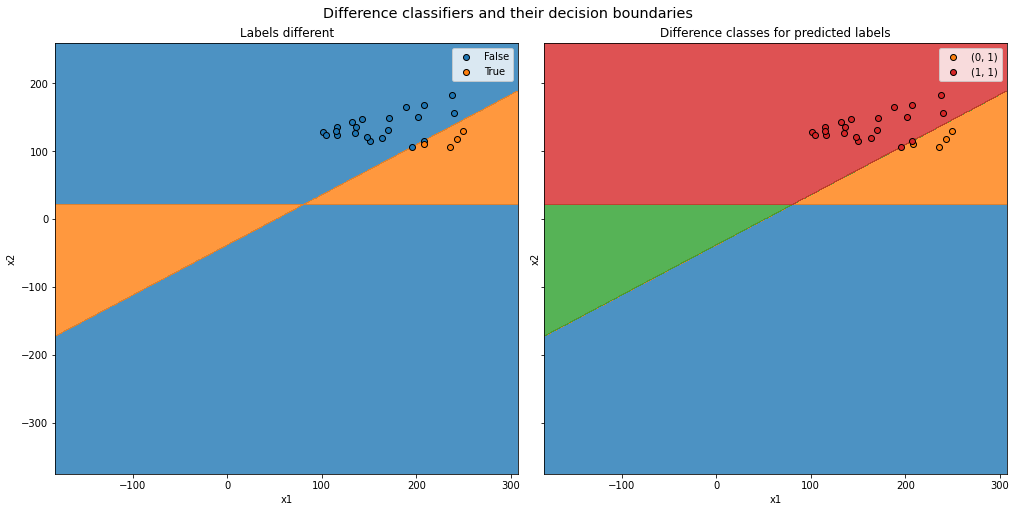

In [77]:
comparer.plot_decision_boundaries(node.parent.parent.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLR

In [78]:
node = node.root.get('RR')
node.class_counts, node.distance

((1, 1)    109
 (0, 0)     53
 (0, 1)     18
 (1, 0)     15
 dtype: int64,
 117.26265834323576)

In [79]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    99
 (0, 1)    18
 (0, 0)    11
 (1, 0)     3
 dtype: int64,
 60.36134690592047)

In [80]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    49
 (0, 1)    18
 (0, 0)    11
 (1, 0)     3
 dtype: int64,
 36.219047895379745)

In [81]:
node.get_left().class_counts

(1, 1)    13
(0, 1)    11
(0, 0)    11
(1, 0)     3
dtype: int64

Compared to the last node I interpreted, this has a high distance.

94.55361439361346 <= x1
x1 <= 81.0 --> {'(1, 1)': 18}


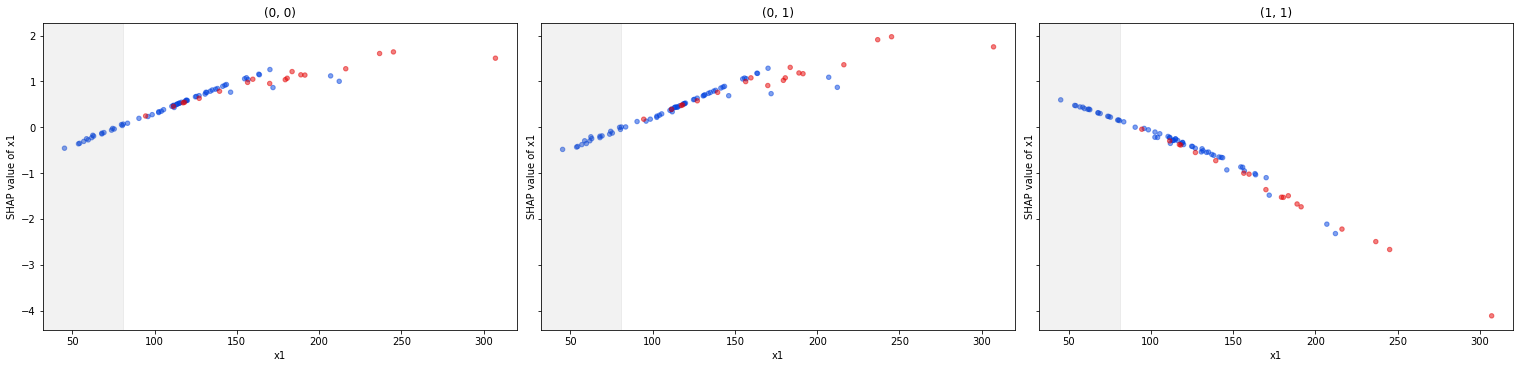

21.71322062603863 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 18}
x2 >= 189.0 --> {'(1, 1)': 18}


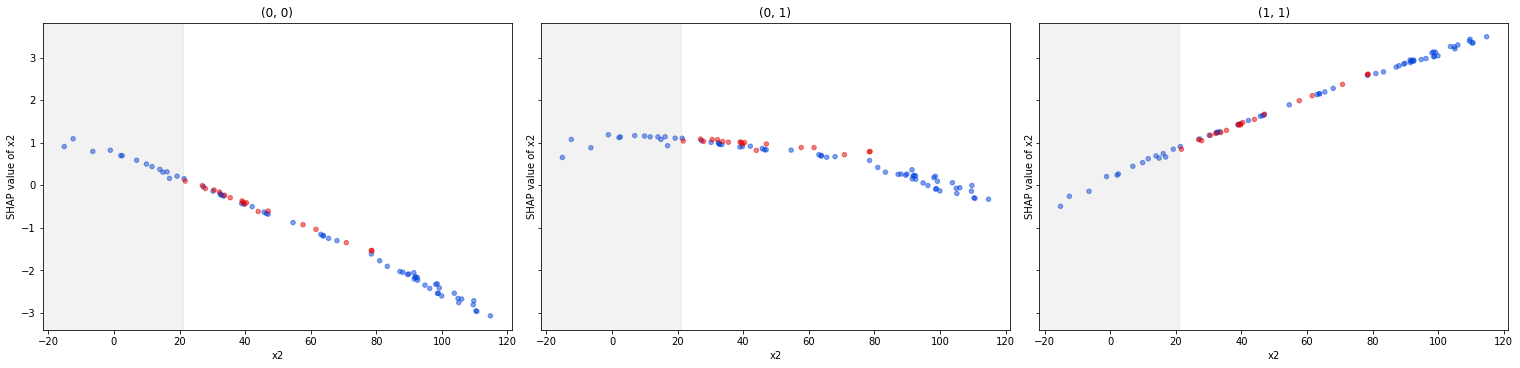

In [83]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature(feature, focus=node, alpha=0.5)

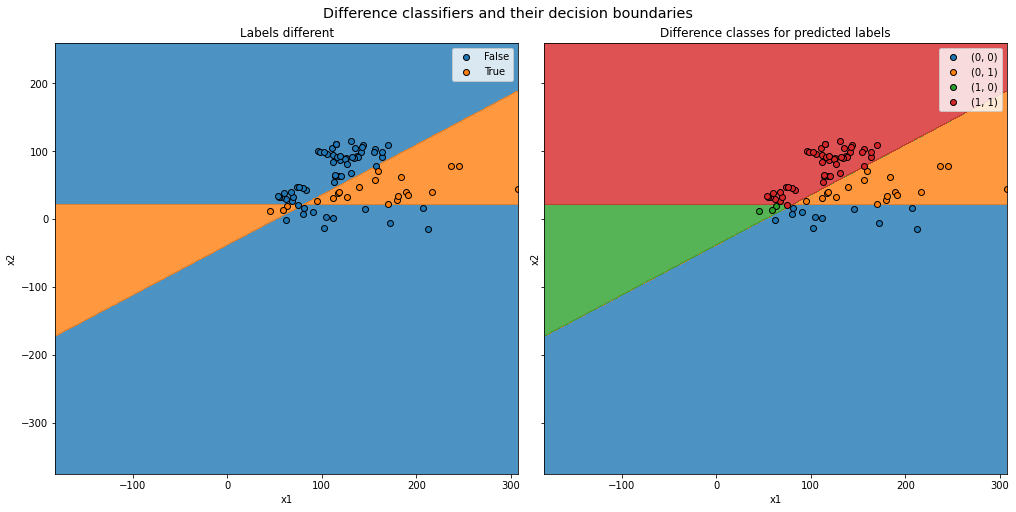

In [84]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLRL

In [85]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    13
 (0, 1)    11
 (0, 0)    11
 (1, 0)     3
 dtype: int64,
 16.081186720830175)

In [86]:
node.get_left().class_counts

(0, 1)    6
(0, 0)    4
dtype: int64

Still, the distance is rather high.

94.55361439361346 <= x1 <= 216.1911730686155
x1 <= 81.0 --> {'(1, 1)': 11}


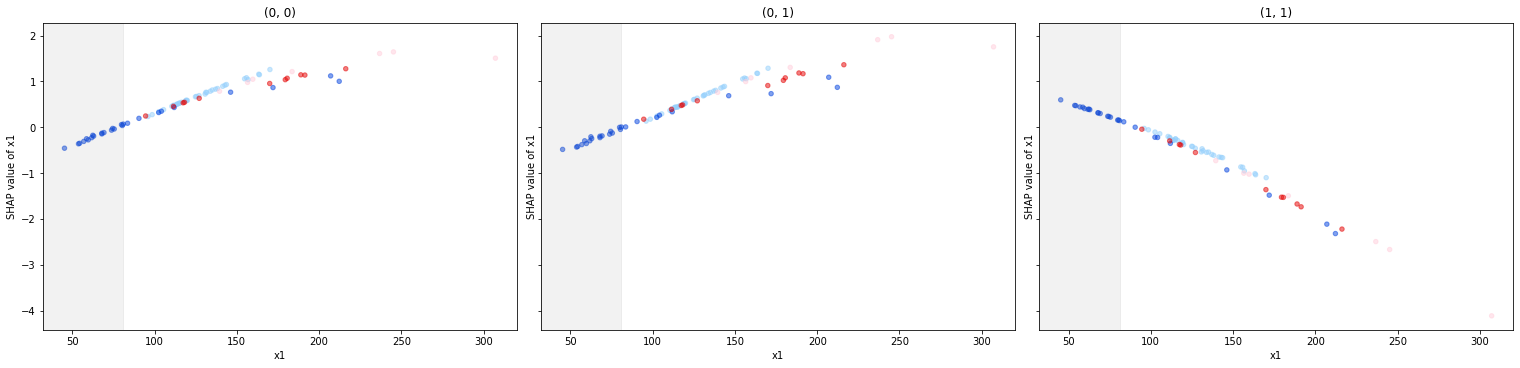

21.71322062603863 <= x2 <= 40.42060515353158
x2 <= 21.0 --> {'(0, 0)': 11}
x2 >= 122.0 --> {'(1, 1)': 11}


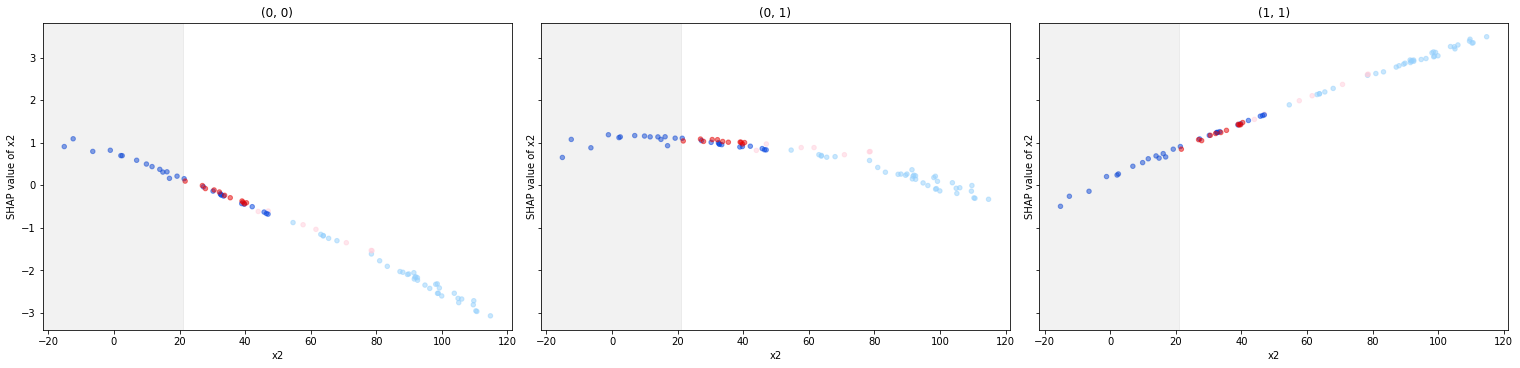

In [87]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

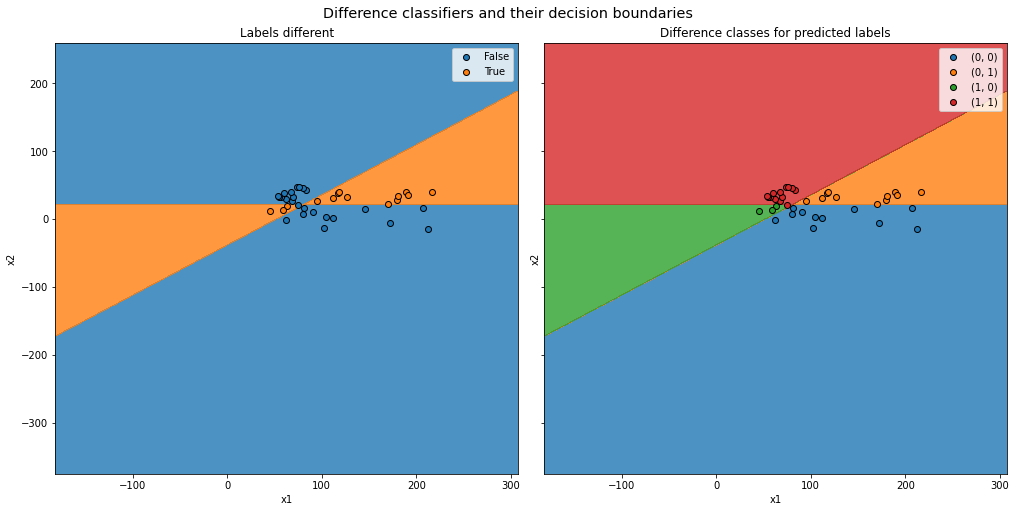

In [88]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLRLLR

In [89]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    6
 (0, 0)    4
 dtype: int64,
 6.024337627233686)

In [93]:
node = node.get_right()
node.class_counts, node.distance

((0, 1)    6
 (0, 0)    2
 dtype: int64,
 3.565646207734325)

In [94]:
node.get_left().class_counts

(0, 0)    1
(0, 1)    1
dtype: int64

169.96479241673015 <= x1 <= 216.1911730686155
x1 <= 81.0 --> {'(1, 1)': 6}


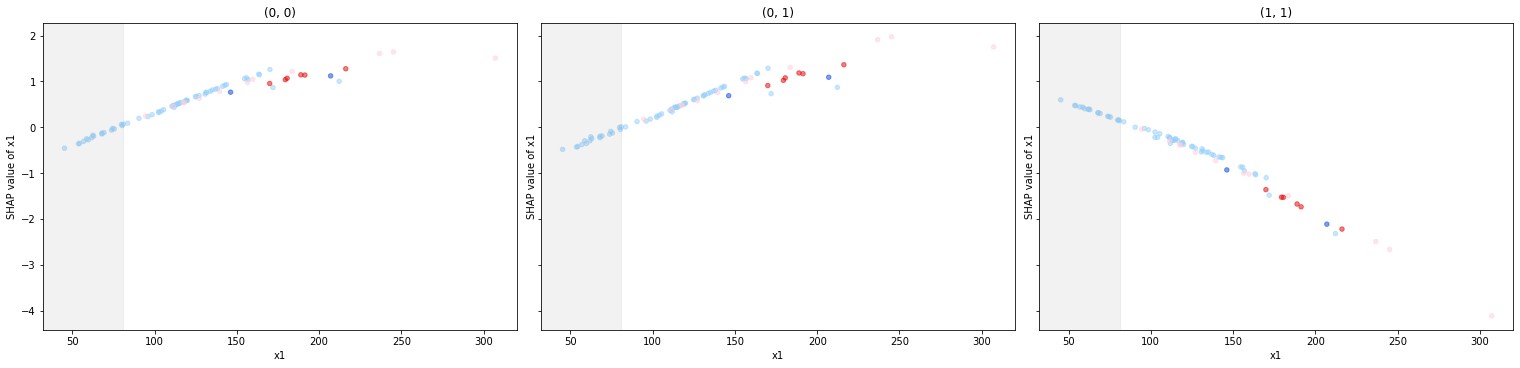

21.71322062603863 <= x2 <= 39.793865327223976
x2 <= 21.0 --> {'(0, 0)': 6}
x2 >= 122.0 --> {'(1, 1)': 6}


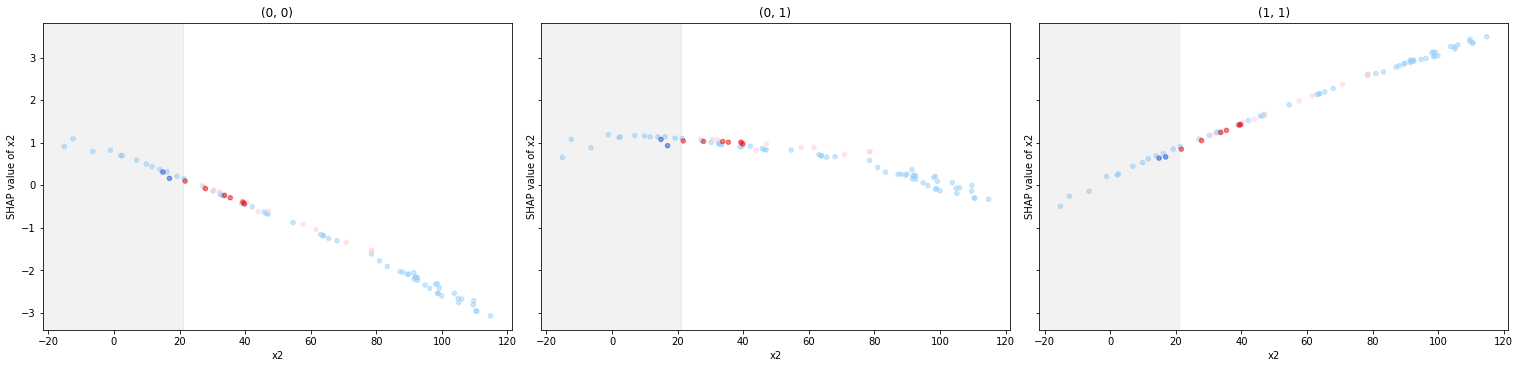

In [95]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

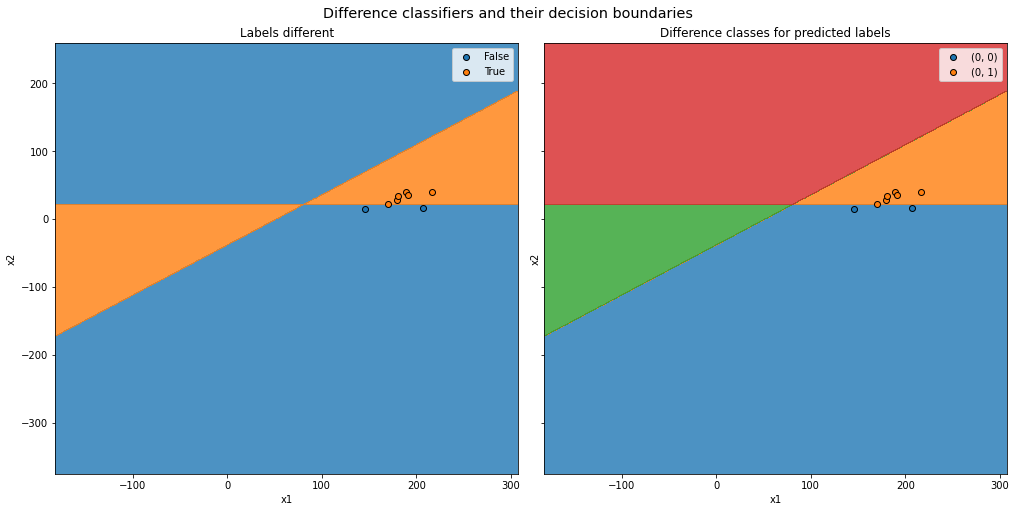

In [101]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLRLRRR

In [102]:
node = node.root.get('RRLRLR')
node.class_counts, node.distance

((1, 1)    13
 (0, 0)     7
 (0, 1)     5
 (1, 0)     3
 dtype: int64,
 7.298313834796821)

In [107]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    13
 (0, 1)     5
 (0, 0)     1
 dtype: int64,
 3.081097411172358)

In [108]:
node = node.get_right()
node.class_counts, node.distance

((0, 1)    5
 (1, 1)    1
 (0, 0)    1
 dtype: int64,
 1.8236273378078334)

In [109]:
node.get_left().class_counts

(0, 1)    4
dtype: int64

94.55361439361346 <= x1 <= 127.11742133952461
x1 <= 88.0 --> {'(1, 1)': 5}


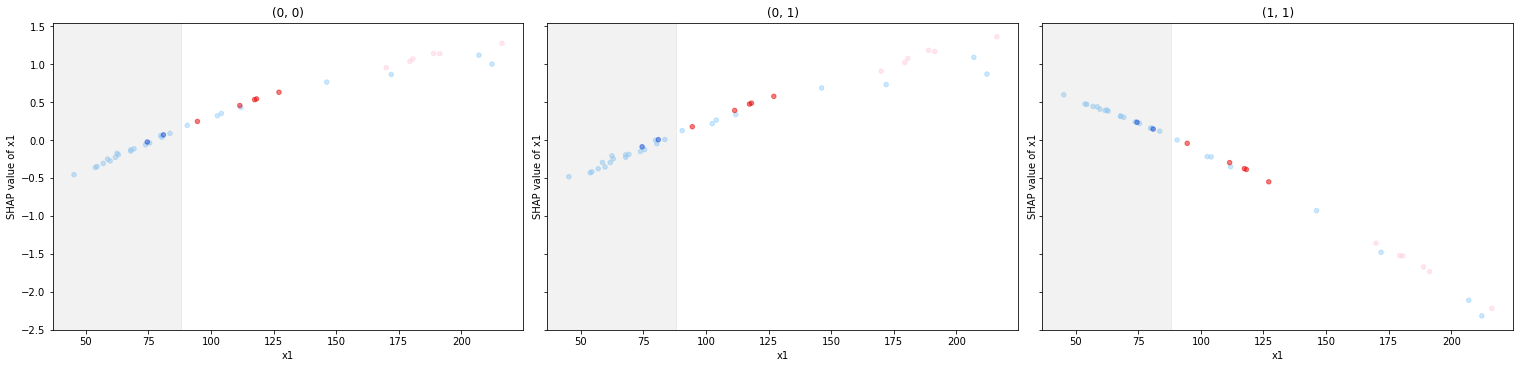

26.970401508651175 <= x2 <= 40.42060515353158
x2 <= 21.0 --> {'(0, 0)': 5}
x2 >= 56.0 --> {'(1, 1)': 5}


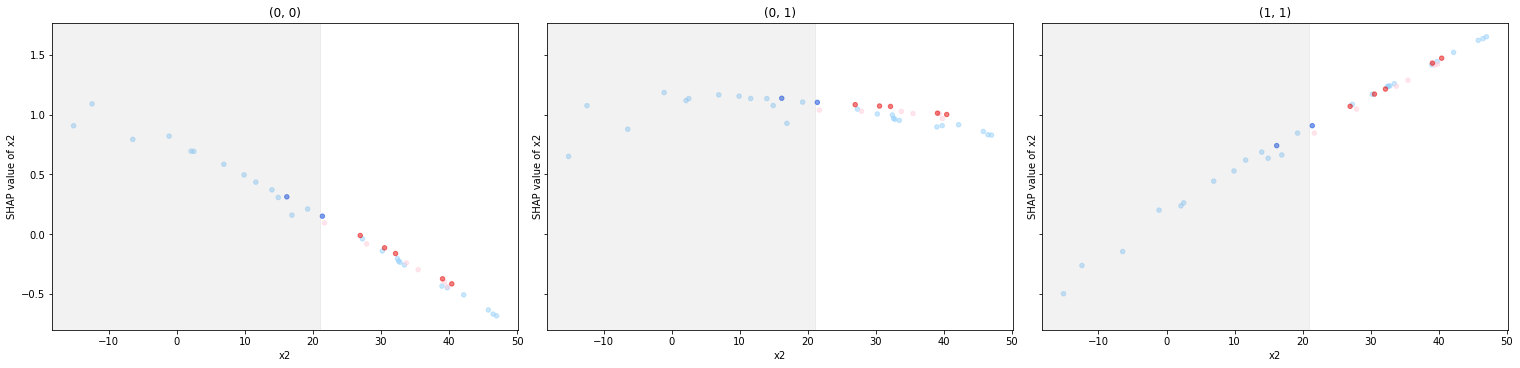

In [110]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

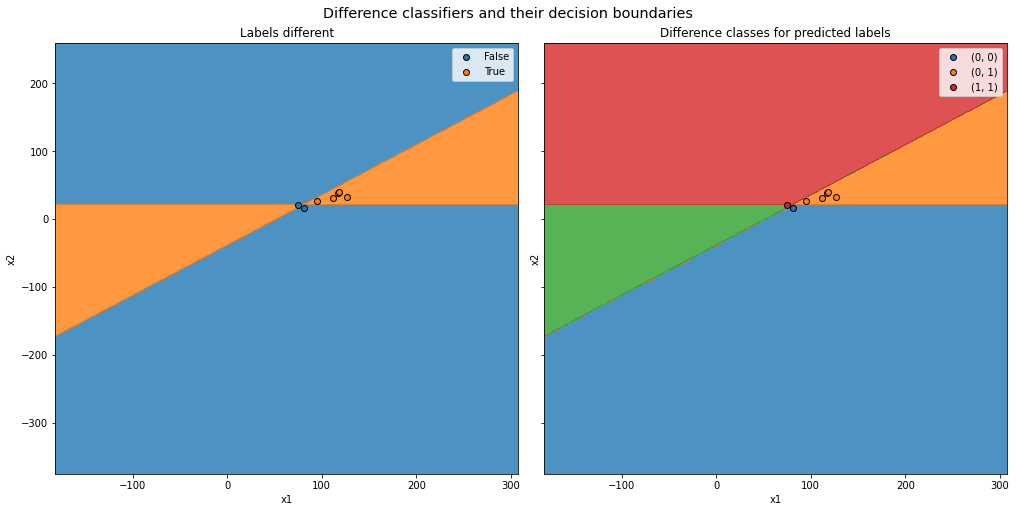

In [111]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLRR

In [112]:
node = node.root.get('RRLRR')
node.class_counts, node.distance

((1, 1)    36
 (0, 1)     7
 dtype: int64,
 28.04230560856923)

In [113]:
node.get_left().class_counts

(0, 1)    3
dtype: int64

139.48436302869598 <= x1
x1 <= 111.0 --> {'(1, 1)': 7}


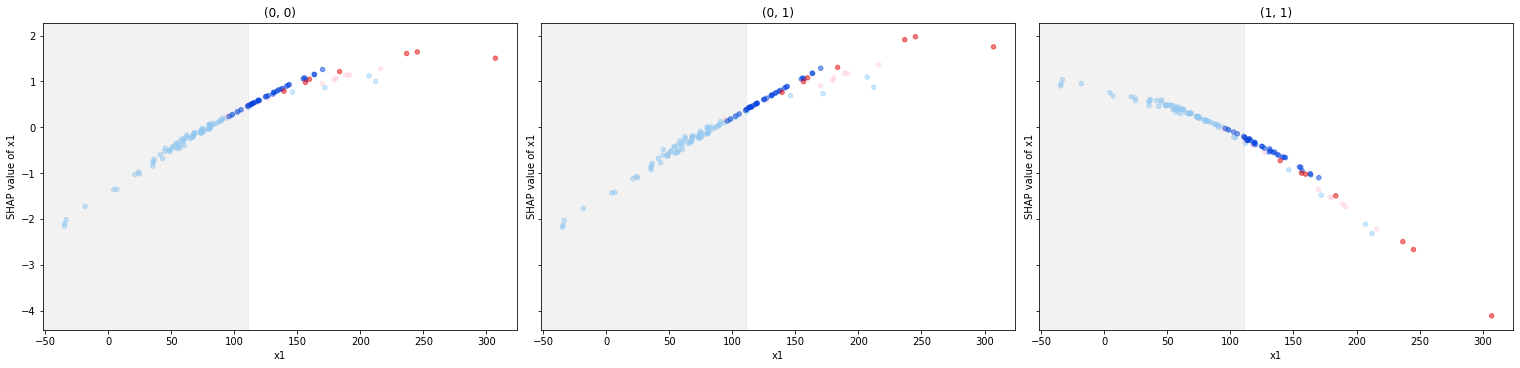

43.996255745135436 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 7}
x2 >= 189.0 --> {'(1, 1)': 7}


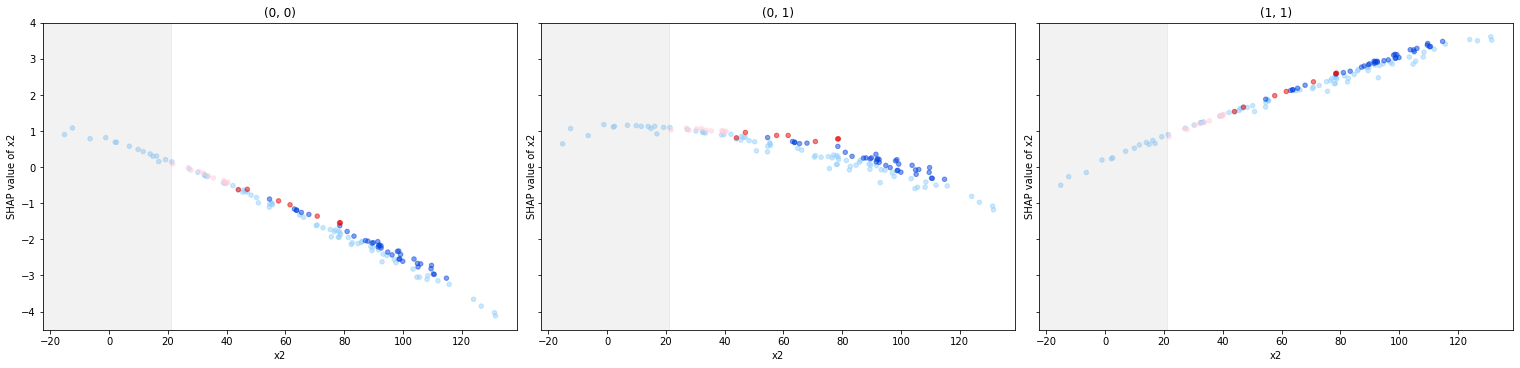

In [114]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

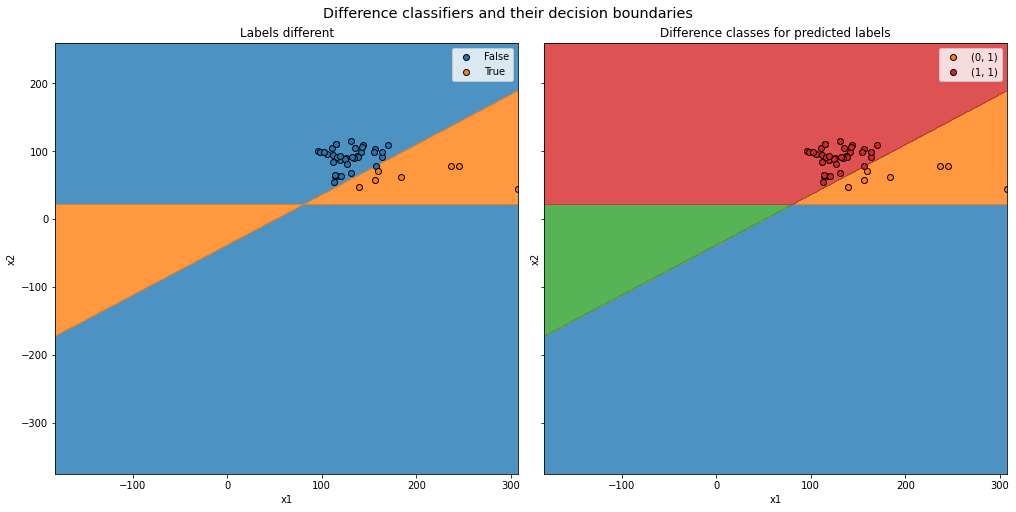

In [115]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLRRL

In [116]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    3
 dtype: int64,
 4.611529916290334)

236.75428302388113 <= x1
x1 <= 111.0 --> {'(1, 1)': 3}


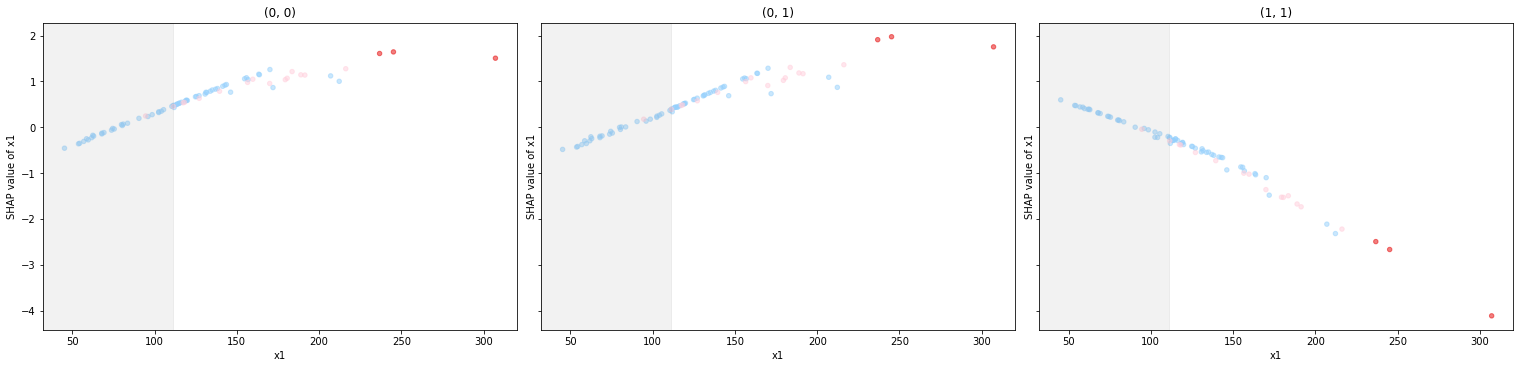

43.996255745135436 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 3}
x2 >= 189.0 --> {'(1, 1)': 3}


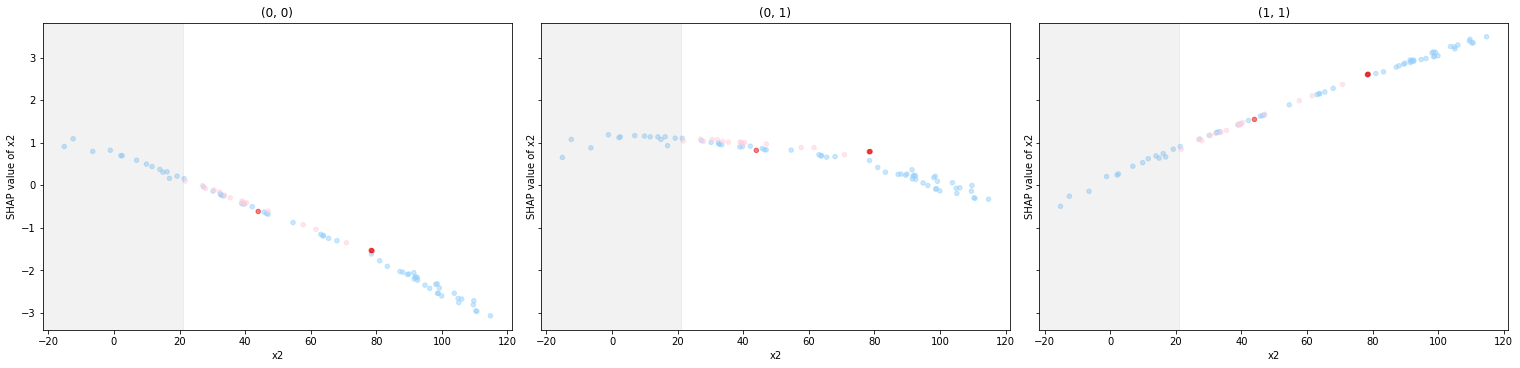

In [117]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

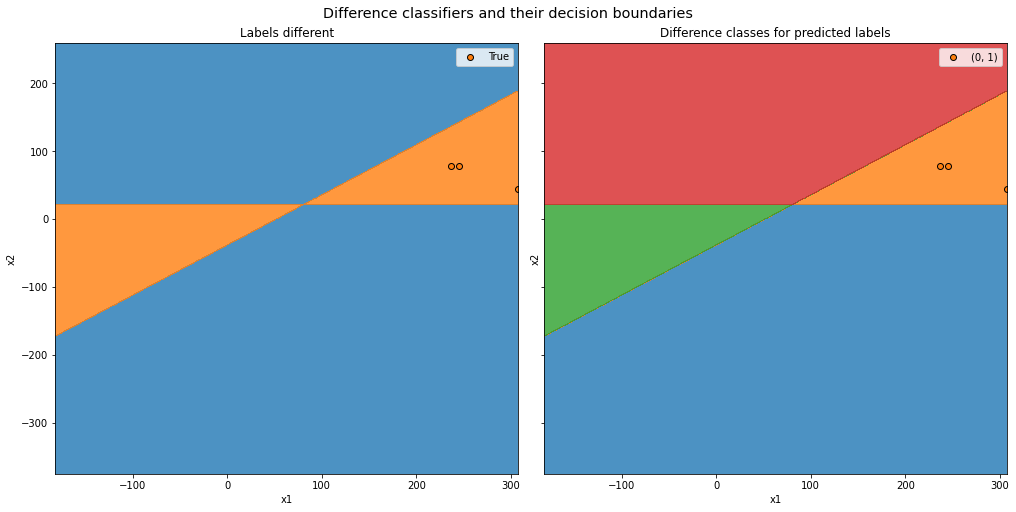

In [118]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLRRR

In [119]:
node = node.parent.get_right()
node.class_counts, node.distance

((1, 1)    36
 (0, 1)     4
 dtype: int64,
 11.15101025074153)

In [122]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    7
 (0, 1)    4
 dtype: int64,
 2.8133220969837396)

In [123]:
node.get_left().class_counts

(0, 1)    2
(1, 1)    1
dtype: int64

139.48436302869598 <= x1 <= 183.57246002956597
x1 <= 115.0 --> {'(1, 1)': 4}


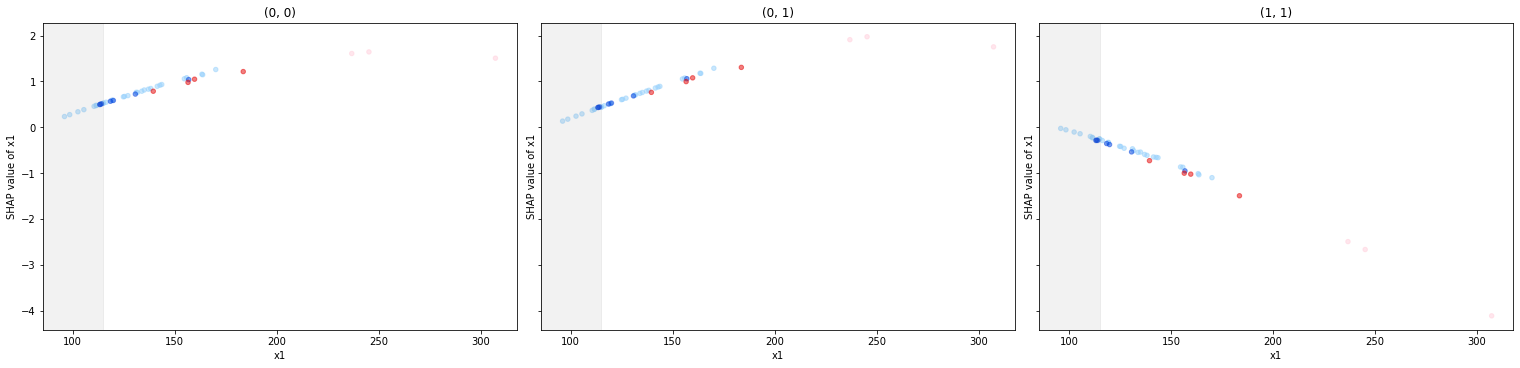

47.04445250884422 <= x2 <= 70.8584634570066
x2 <= 21.0 --> {'(0, 0)': 4}
x2 >= 98.0 --> {'(1, 1)': 4}


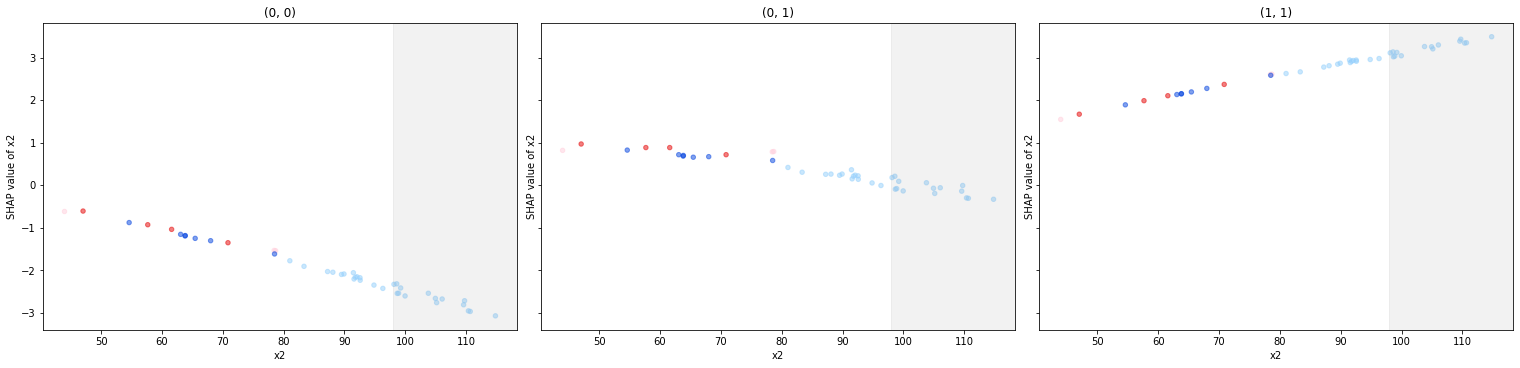

In [124]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

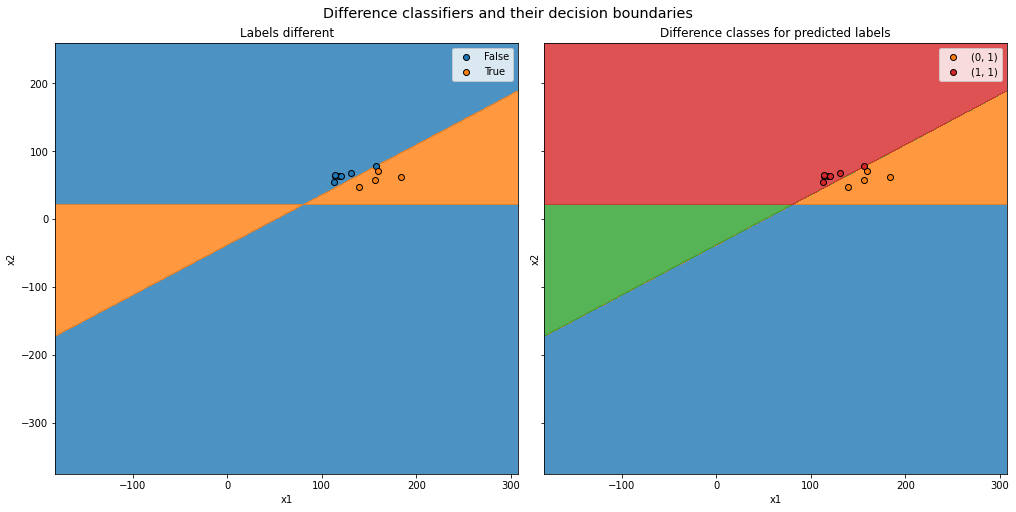

In [125]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Explanation Summary
$94<x1<308, 21<x2<131$ (22)
- CF: $x1≤81 \rightarrow (1,1)$
- CF: $x2≤21 \rightarrow (0,0)$
- CF: $x2≥189 \rightarrow (1,1)$
- RL: $207<x1, 105<x2$ (4)
    - CF: $x1≤194 \rightarrow (1,1)$
    - CF: $x2≤21 \rightarrow (0,0)$
    - CF: $x2≥146 \rightarrow (1,1)$
- RRLR: $207<x1, 21<x2<79$ (18)
    - CF: $x1≤81 \rightarrow (1,1)$
    - CF: $x2≤21 \rightarrow (0,0)$
    - CF: $x2≥189 \rightarrow (1,1)$
    - RRLRL: $94<x1<216, 21<x2<40$ (11)
        - CF: $x1≤81 \rightarrow (1,1)$
        - CF: $x2≤21 \rightarrow (0,0)$
        - CF: $x2≥122 \rightarrow (1,1)$
    - RRLRR: $139<x1, 43<x2<79$ (7)
        - CF: $x1≤111 \rightarrow (1,1)$
        - CF: $x2≤21 \rightarrow (0,0)$
        - CF: $x2≥189 \rightarrow (1,1)$

- rule 1 ($(0,1)$/node RL): $194<x1, 105<x2 \rightarrow (0,1)$
- rule 2 ($(0,1)$/node RL): $207<x1, 21<x2<146 \rightarrow (0,1)$
- rule 3 ($(0,1)$/node RRLRL): $81<x1<216, 21<x2<40 \rightarrow (0,1)$
- rule 4 ($(0,1)$/node RRLRL): $94<x1<216, 21<x2<122 \rightarrow (0,1)$
- rule 6 ($(0,1)$/node RRLRR): $111<x1, 43<x2<79 \rightarrow (0,1)$
- rule 7 ($(0,1)$/node RRLRR): $139<x1, 21<x2<189 \rightarrow (0,1)$

## Clustering of Class $(1, 0)$ SHAP Values

In [78]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                          feature_precisions=feature_precisions)

### Root Node

In [14]:
node.class_counts, node.distance

((1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 882.7363012595714)

-43.73613231796008 <= x1 <= 62.966519499503526
x1 >= 77.82 --> {'(0, 0)': 15}


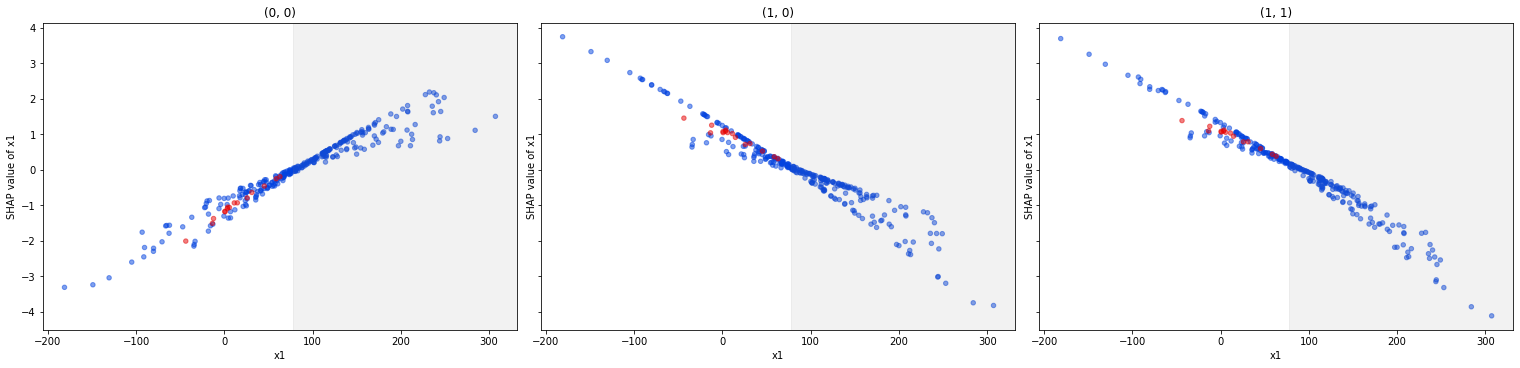

-27.904182410204744 <= x2 <= 19.24556227701676
x2 <= -70.43 --> {'(0, 0)': 15}
x2 >= 21.36 --> {'(1, 1)': 15}


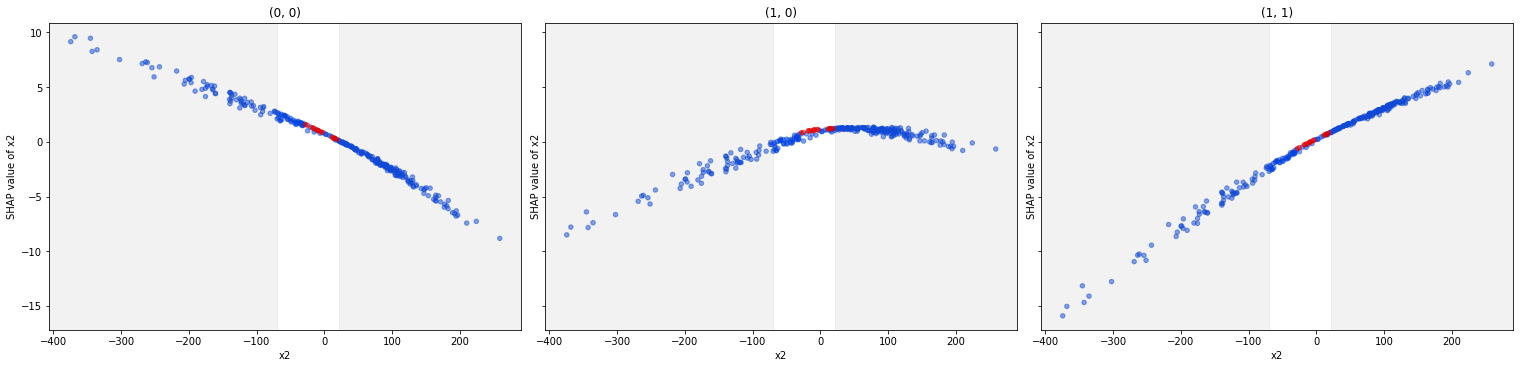

In [79]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature(feature, alpha=0.5)

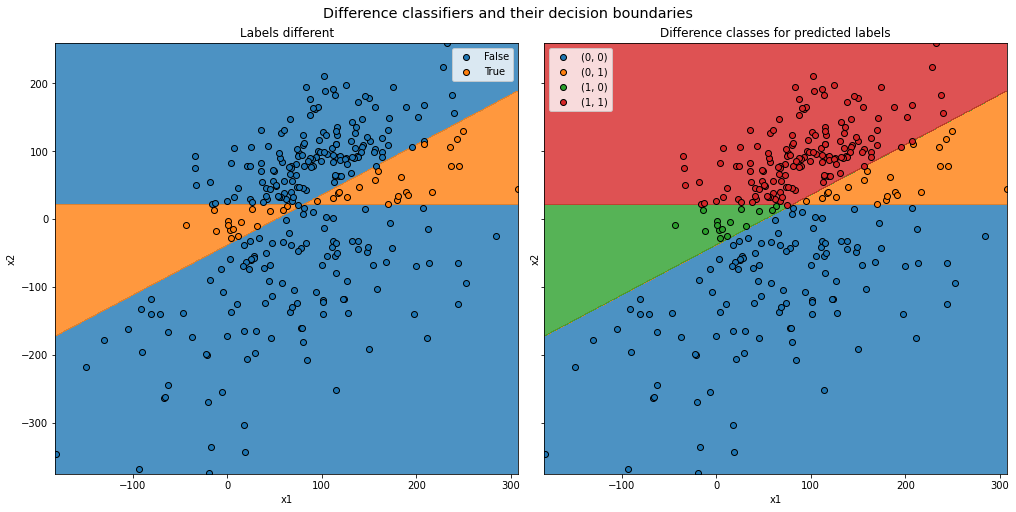

In [80]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node L

In [81]:
node = node.get_left()
node.class_counts, node.distance

(1, 1)    149
(0, 0)     49
(0, 1)     22
(1, 0)     15
dtype: int64

-43.73613231796008 <= x1 <= 62.966519499503526
x1 >= 77.82 --> {'(0, 0)': 15}


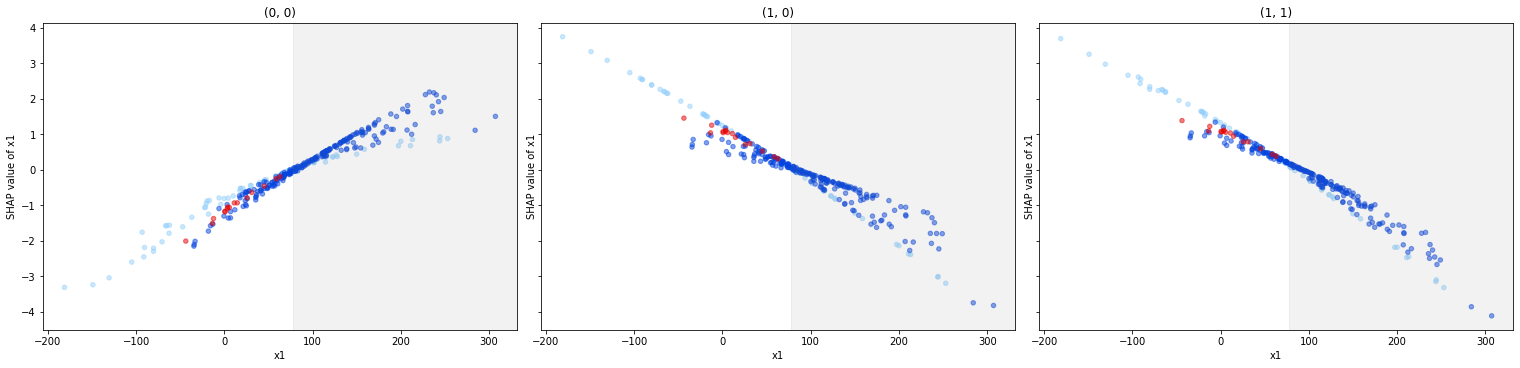

-27.904182410204744 <= x2 <= 19.24556227701676
x2 <= -70.43 --> {'(0, 0)': 15}
x2 >= 21.36 --> {'(1, 1)': 15}


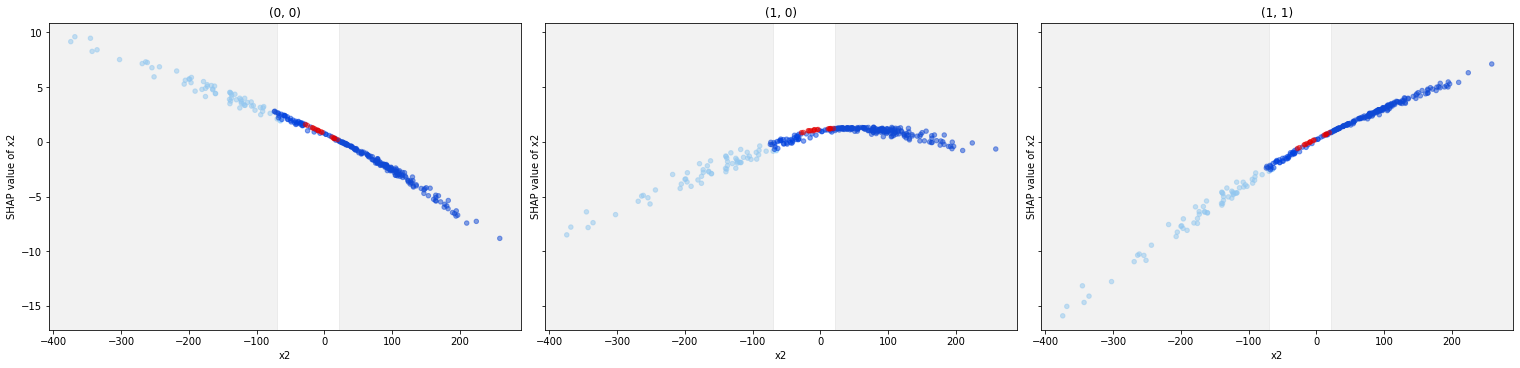

In [82]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

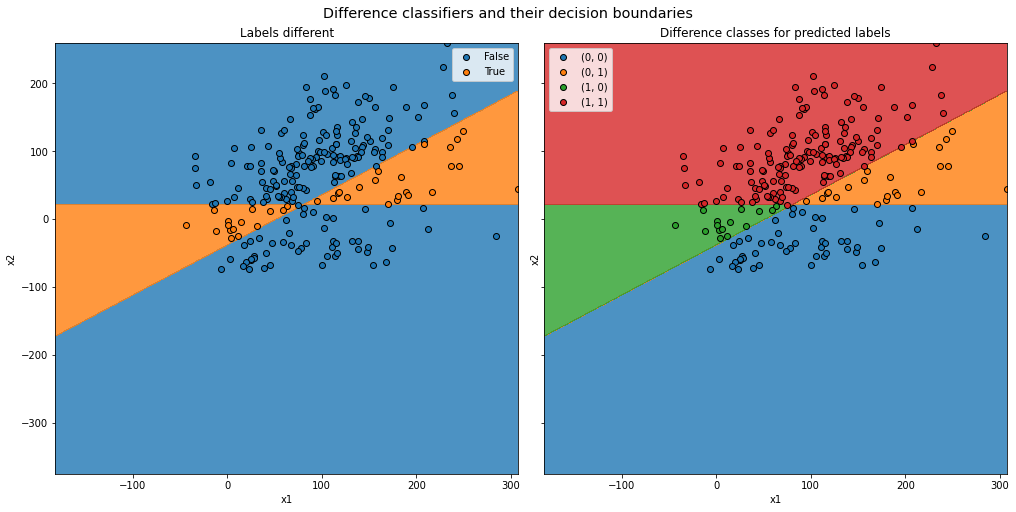

In [83]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node LR

In [84]:
node = node.get_right()
node.class_counts, node.distance

(1, 1)    126
(0, 0)     49
(0, 1)     22
(1, 0)     15
dtype: int64

-43.73613231796008 <= x1 <= 62.966519499503526
x1 >= 77.82 --> {'(0, 0)': 15}


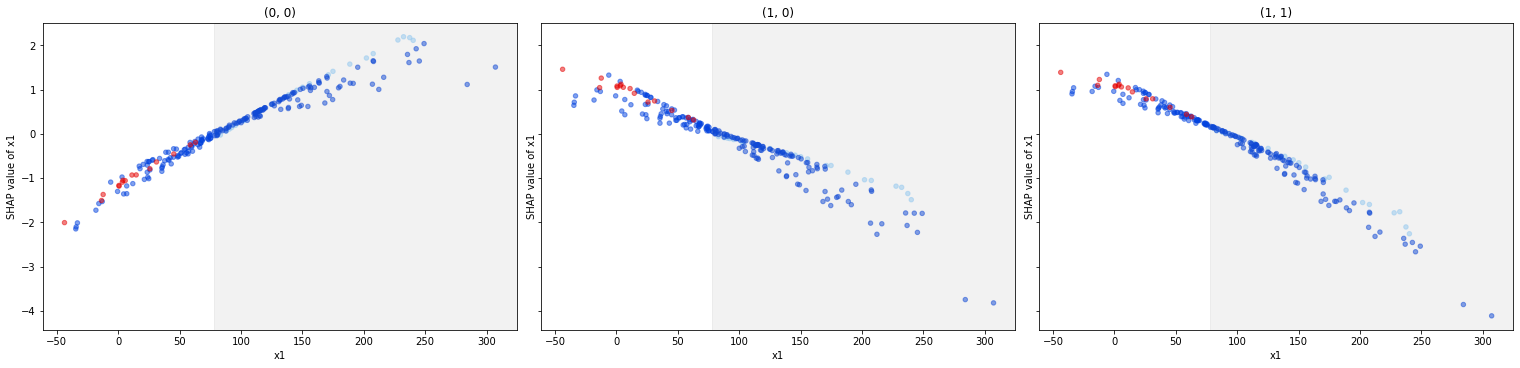

-27.904182410204744 <= x2 <= 19.24556227701676
x2 <= -70.43 --> {'(0, 0)': 15}
x2 >= 21.36 --> {'(1, 1)': 15}


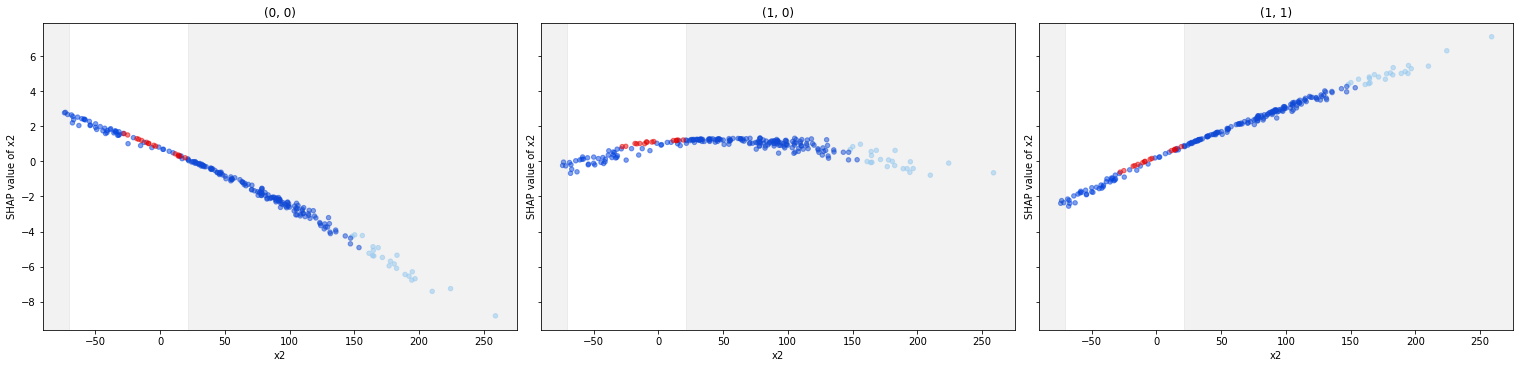

In [85]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

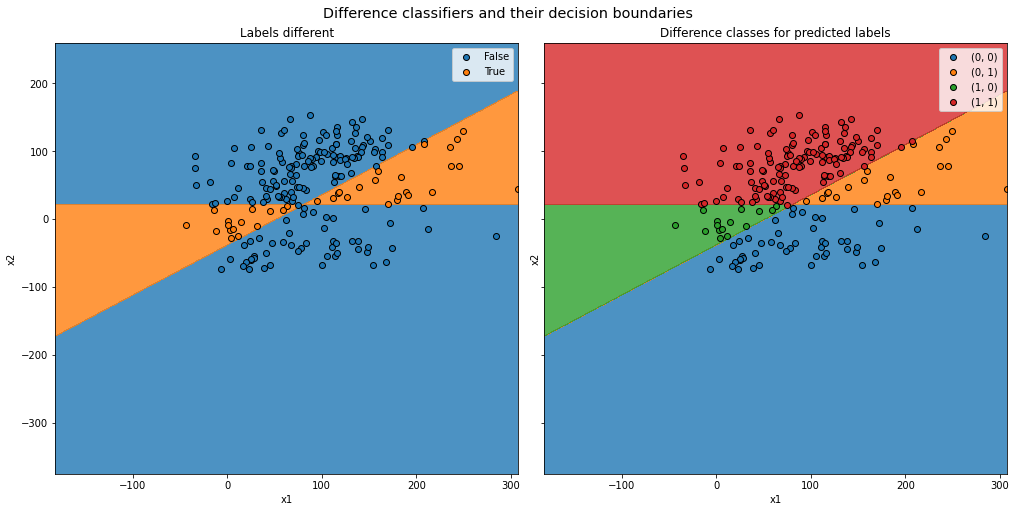

In [86]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node LRL

In [87]:
node = node.get_left()
node.class_counts, node.distance

(1, 1)    125
(0, 1)     16
(1, 0)      3
(0, 0)      1
dtype: int64

-13.608547578550045 <= x1 <= 45.255411008301124
x1 >= 72.28 --> {'(0, 0)': 3}


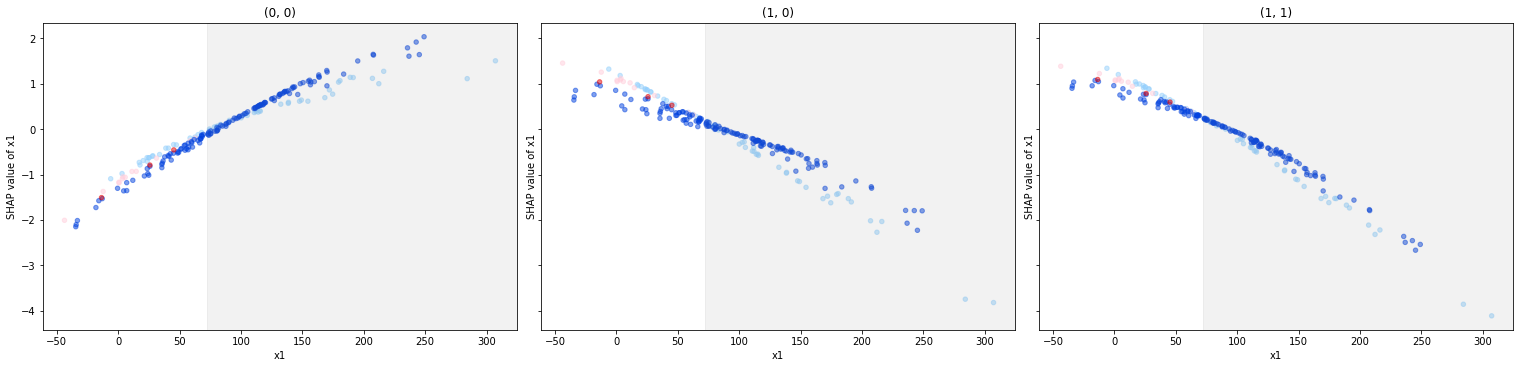

11.625023695822245 <= x2 <= 15.157493874171458
x2 <= -48.2 --> {'(0, 0)': 3}
x2 >= 21.36 --> {'(1, 1)': 3}


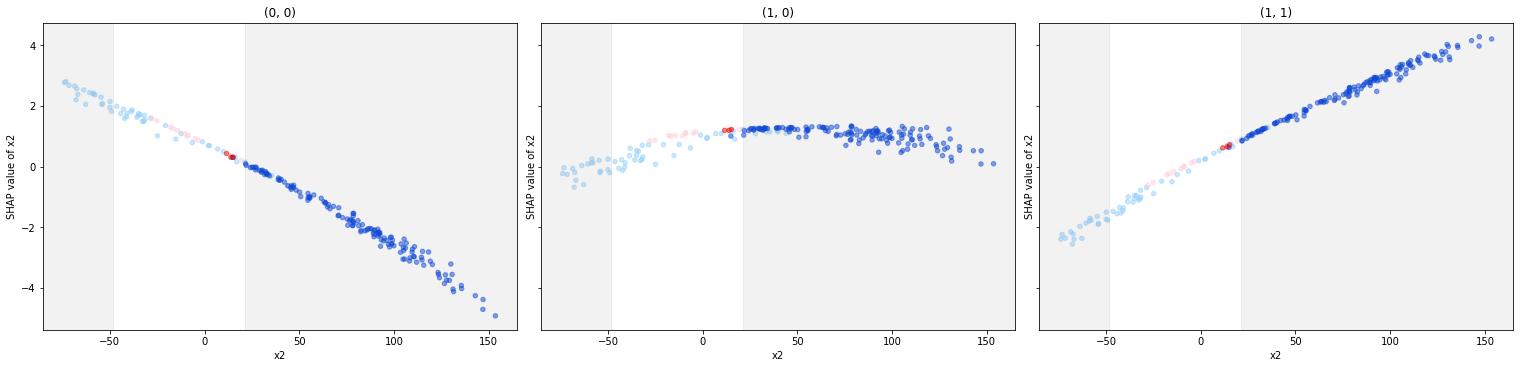

In [88]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

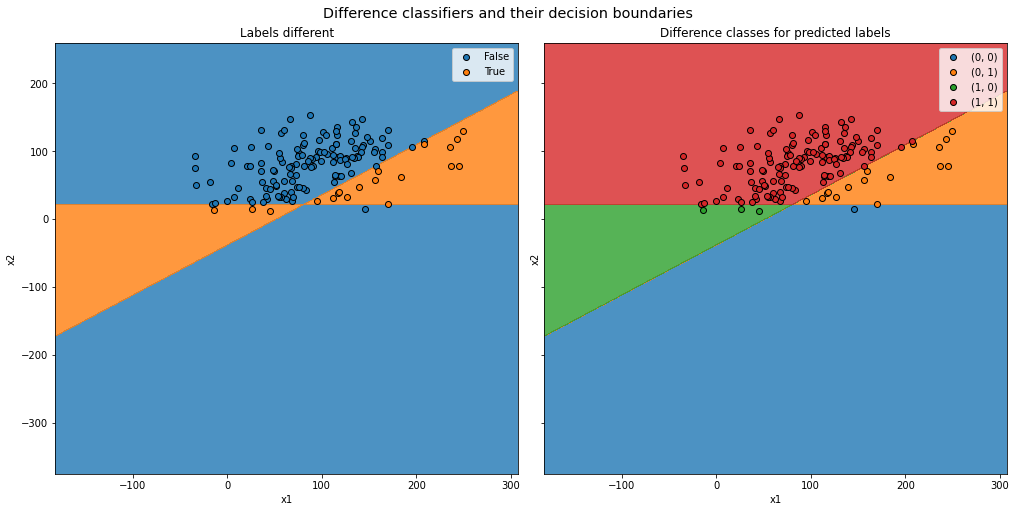

In [89]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node LRR

In [90]:
node = node.parent.get_right()
node.class_counts, node.distance

(0, 0)    48
(1, 0)    12
(0, 1)     6
(1, 1)     1
dtype: int64

-43.73613231796008 <= x1 <= 62.966519499503526
x1 >= 77.82 --> {'(0, 0)': 12}


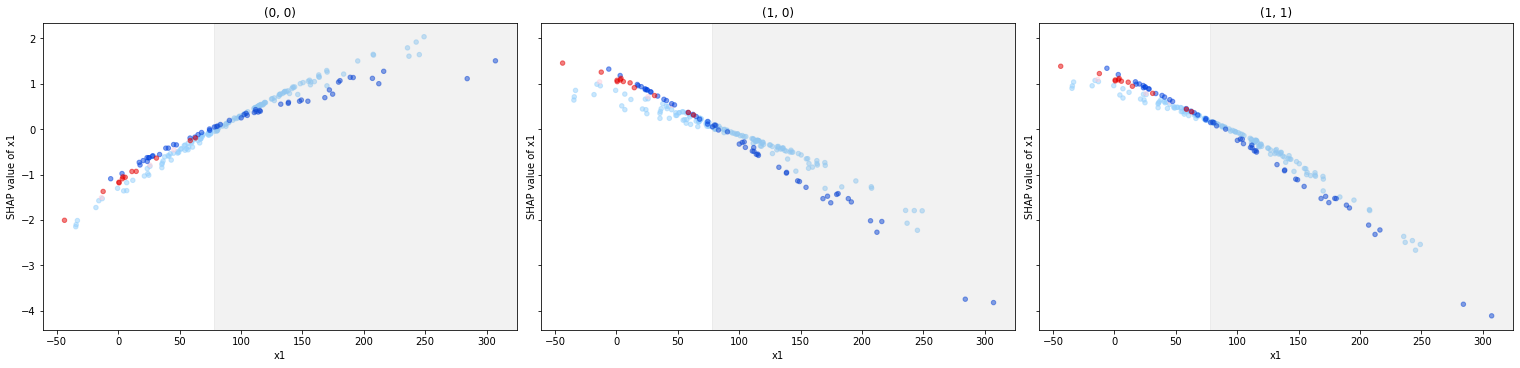

-27.904182410204744 <= x2 <= 19.24556227701676
x2 <= -70.43 --> {'(0, 0)': 12}
x2 >= 21.36 --> {'(1, 1)': 12}


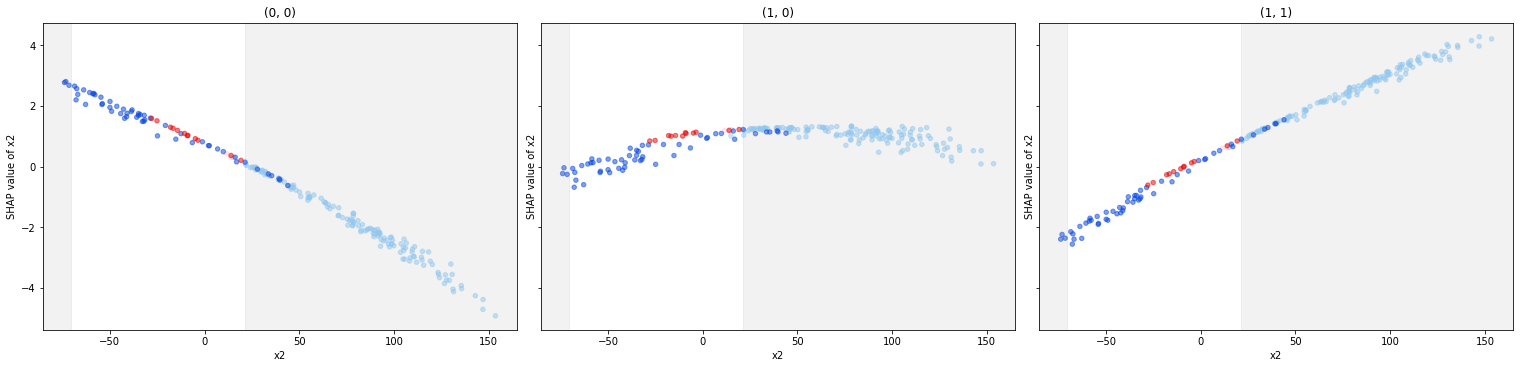

In [91]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

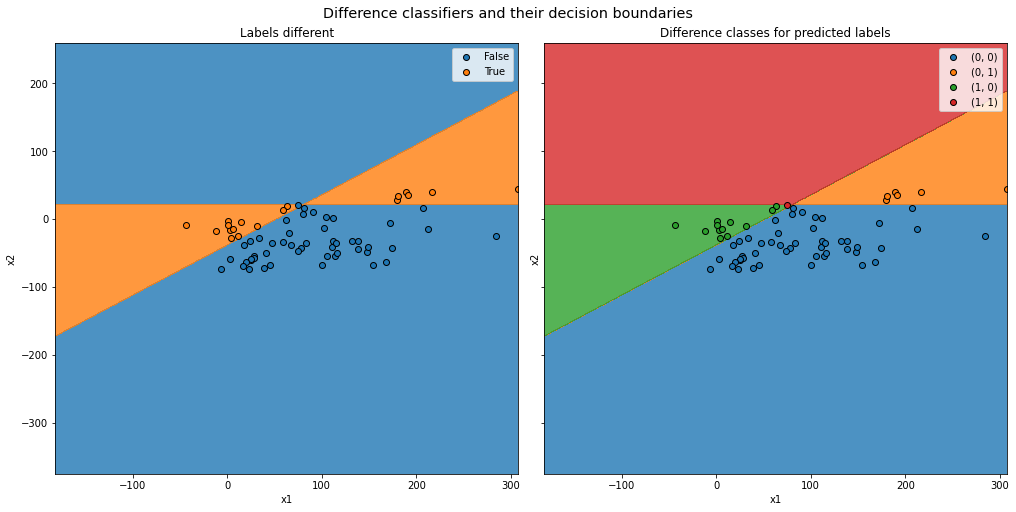

In [92]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node LRRRRRL

In [93]:
node = node.get_right()
node.class_counts, node.distance

(0, 0)    44
(1, 0)    12
(1, 1)     1
dtype: int64

In [94]:
node = node.get_right()
node.class_counts, node.distance

(0, 0)    29
(1, 0)    12
(1, 1)     1
dtype: int64

In [95]:
node = node.get_right()
node.class_counts, node.distance

(1, 0)    12
(0, 0)     7
(1, 1)     1
dtype: int64

In [96]:
node = node.get_left()
node.class_counts, node.distance

(1, 0)    10
dtype: int64

-43.73613231796008 <= x1 <= 31.13504268158801
x1 >= 47.05 --> {'(0, 0)': 10}


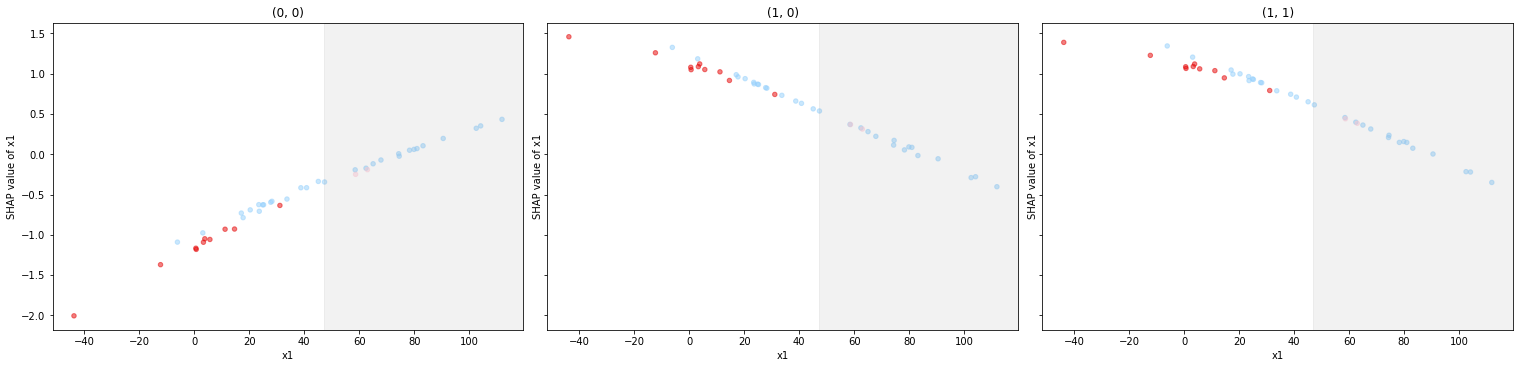

-27.904182410204744 <= x2 <= -3.454652008977943
x2 <= -70.43 --> {'(0, 0)': 10}
x2 >= 21.36 --> {'(1, 1)': 10}


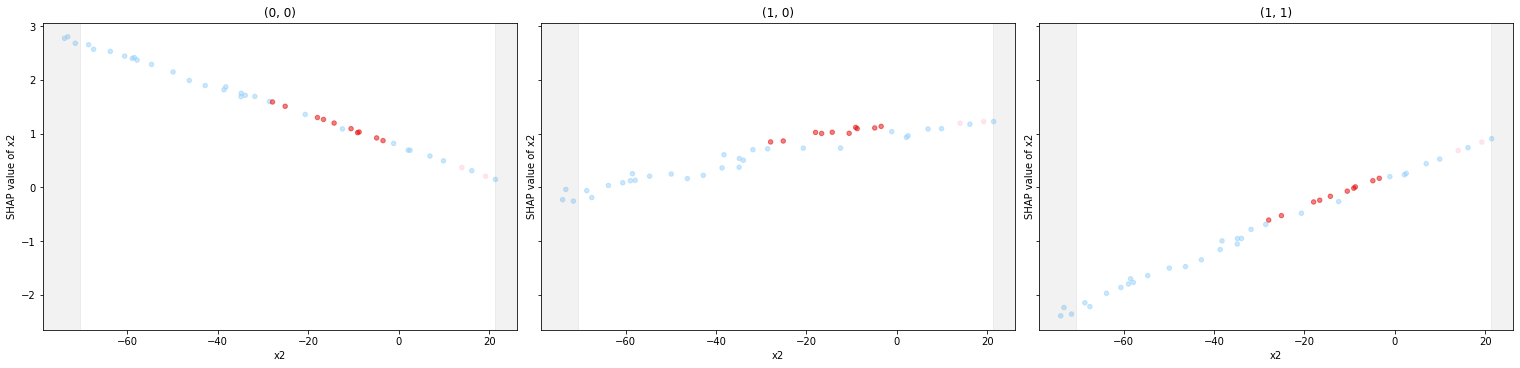

In [99]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

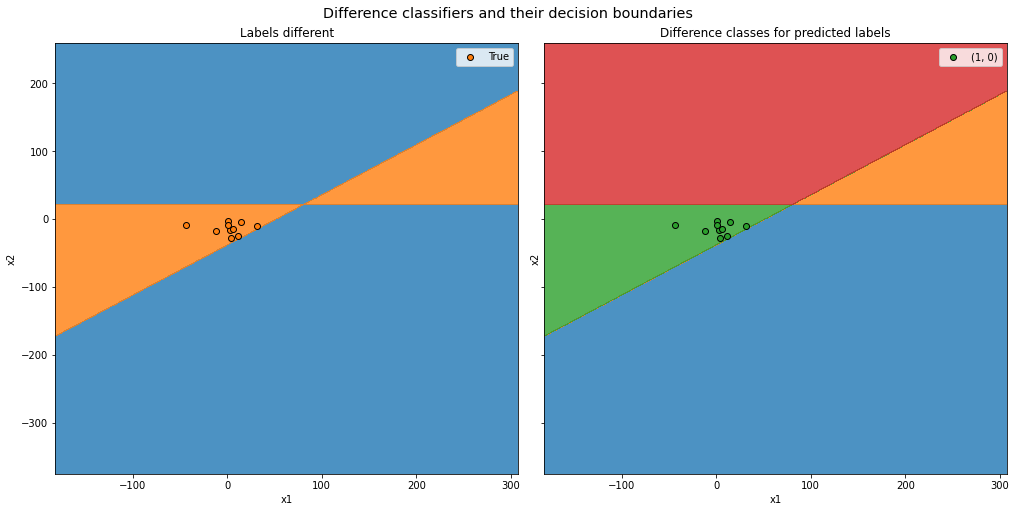

In [98]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node LRRRRRR

In [100]:
node = node.parent.get_right()
node.class_counts, node.distance

(0, 0)    7
(1, 0)    2
(1, 1)    1
dtype: int64

58.66508979458671 <= x1 <= 62.966519499503526
x1 >= 77.82 --> {'(0, 0)': 2}


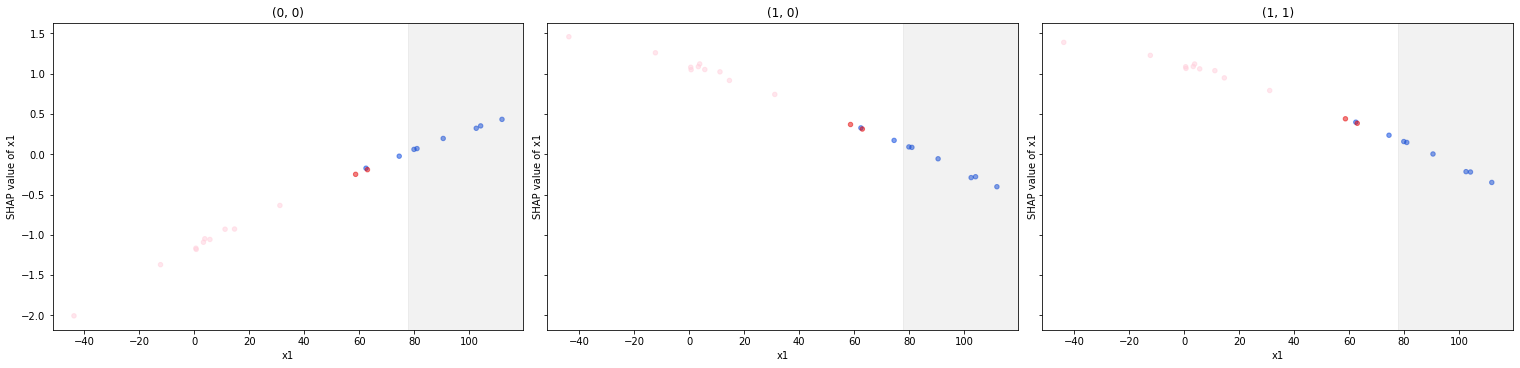

13.99257944405421 <= x2 <= 19.24556227701676
x2 <= 5.11 --> {'(0, 0)': 2}
x2 >= 21.36 --> {'(1, 1)': 2}


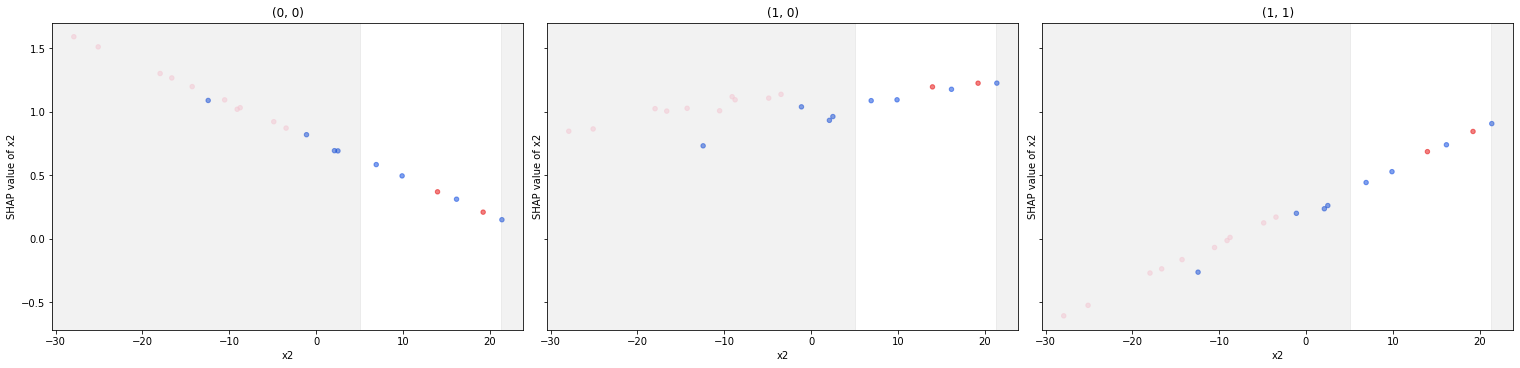

In [101]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

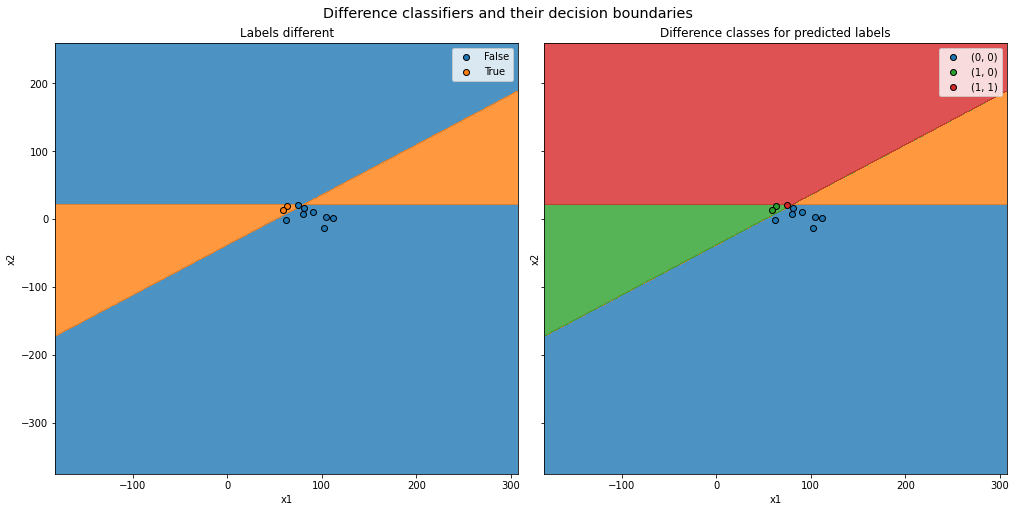

In [102]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Explanation Summary
$-44<x1<63, -28<x2<20$ (15)
- CF: $x1≥78 \rightarrow (0,0)$
- CF: $x2≤-71 \rightarrow (0,0)$
- CF: $x2≥22 \rightarrow (1,1)$
- node LRL: $-14<x1<45, 11<x2<16$ (3)
    - CF: $x1≥73 \rightarrow (0,0)$
    - CF: $x2≤-49 \rightarrow (0,0)$
    - CF: $x2≥22 \rightarrow (1,1)$
- node LRR: $-44<x1<63, -28<x2<20$ (12)
    - CF: $x1≥78 \rightarrow (0,0)$
    - CF: $x2≤-71 \rightarrow (0,0)$
    - CF: $x2≥22 \rightarrow (1,1)$
    - node LRRRRRL: $-44<x1<32, -28<x2<-3$ (10)
        - CF: $x1≥48 \rightarrow (0,0)$
        - CF: $x2≤-71 \rightarrow (0,0)$
        - CF: $x2≥22 \rightarrow (1,1)$
    - node LRRRRRR: $58<x1<63, 13<x2<20$ (2)
        - CF: $x1≥78 \rightarrow (0,0)$
        - CF: $x2≤5 \rightarrow (0,0)$
        - CF: $x2≥22 \rightarrow (1,1)$

# Explanation

- rule 8 ($(1,0)$/node LRL): $-14<x1<73, 11<x2<16 \rightarrow (1,0)$
- rule 9 ($(1,0)$/node LRL): $-14<x1<45, -49<x2<22 \rightarrow (1,0)$
- rule 10 ($(1,0)$/node LRRRRRL): $-44<x1<48, -28<x2<-3 \rightarrow (1,0)$
- rule 11 ($(1,0)$/node LRRRRRL): $-44<x1<32, -71<x2<22 \rightarrow (1,0)$
- rule 12 ($(1,0)$/node LRRRRRR): $58<x1<78, 13<x2<20 \rightarrow (1,0)$
- rule 13 ($(1,0)$/node LRRRRRR): $58<x1<63, 5<x2<22 \rightarrow (1,0)$

# Evaluation

- evaluate fidelity with precision, recall, f1?
- but what is the ground truth?
- need for programmatic representation?

1. create evenly spaced artifical dataset
2. evaluate rule set on it

In [ ]:
# TODO evaluate explanation for each instance:
- selectivity

# TODO and evaluate overall characteristics
- selectivity